## Necessary Imports

In [1]:
!pip install transformers       
!pip install pillow   
!pip install kagglehub pandas   
!pip install kaggle      
!pip install scikit-learn    

## Swin-Transformer

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, SwinForImageClassification, SwinConfig
import PIL.Image
import os
import pandas as pd
import kagglehub
from typing import Tuple, List, Optional
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from pathlib import Path

class CBISDDSMDataset(Dataset):
    def __init__(self, base_path: str, split: str = 'train', transform=None, use_roi: bool = True):
        self.base_path = base_path
        self.transform = transform
        self.split = split
        self.use_roi = use_roi
        
        self.data = self._load_and_process_data()
        self.pathology_to_label = {
            'BENIGN': 0,
            'BENIGN_WITHOUT_CALLBACK': 0,
            'MALIGNANT': 1
        }

    def _find_valid_image(self, series_uid: str) -> Optional[str]:
        folder_path = os.path.join(self.base_path, 'jpeg', series_uid)
        if not os.path.exists(folder_path):
            return None
            
        jpg_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')])
        if not jpg_files:
            return None
            
        if self.use_roi and len(jpg_files) > 1:
            return os.path.join(folder_path, jpg_files[1])
        return os.path.join(folder_path, jpg_files[0])

    def _process_csv(self, csv_path: str, lesion_type: str) -> List[dict]:
        try:
            df = pd.read_csv(csv_path)
            #print(f"\nProcessing {lesion_type} CSV")
            records = []
            
            # Get available image folders
            jpeg_dir = os.path.join(self.base_path, 'jpeg')
            available_uids = set(os.listdir(jpeg_dir))
            
            for _, row in df.iterrows():
                try:
                    # Extract UIDs from path
                    path = row['cropped image file path'] if self.use_roi else row['image file path']
                    uids = [p for p in path.split('/') if p.startswith('1.3.6.1.4.1.9590.100.1.2.')]
                    
                    # Find matching folder
                    for uid in uids:
                        if uid in available_uids:
                            image_path = self._find_valid_image(uid)
                            if image_path:
                                records.append({
                                    'patient_id': row['patient_id'],
                                    'image_path': image_path,
                                    'pathology': row['pathology'],
                                    'lesion_type': lesion_type,
                                    'breast_side': row['left or right breast'],
                                    'view': row['image view'],
                                    'breast_density': row.get('breast_density', row.get('breast density', None))
                                })
                                #print(f"Match: {uid} -> {row['pathology']}")
                                break
                except Exception as e:
                    #print(f"Error processing row: {e}")
                    continue
            
            #print(f"Found {len(records)} matches")
            return records
            
        except Exception as e:
            #print(f"Error loading CSV: {str(e)}")
            return []

    def _load_and_process_data(self) -> pd.DataFrame:
        records = []
        
        calc_path = os.path.join(self.base_path, 'csv', f'calc_case_description_{self.split}_set.csv')
        mass_path = os.path.join(self.base_path, 'csv', f'mass_case_description_{self.split}_set.csv')
        
        #print(f"\nChecking paths:")
        #print(f"Base path: {self.base_path}")
        #print(f"Calc CSV path: {calc_path} (exists: {os.path.exists(calc_path)})")
        #print(f"Mass CSV path: {mass_path} (exists: {os.path.exists(mass_path)})")
        
        #print("\nDirectory contents:")
        #for root, dirs, files in os.walk(self.base_path):
        #    print(f"\nDirectory: {root}")
        #    if files:
        #        print(f"Files: {files}")
        
        if os.path.exists(calc_path):
            calc_records = self._process_csv(calc_path, 'calc')
            #print(f"\nLoaded {len(calc_records)} calcification records")
            records.extend(calc_records)
        
        if os.path.exists(mass_path):
            mass_records = self._process_csv(mass_path, 'mass')
            #print(f"\nLoaded {len(mass_records)} mass records")
            records.extend(mass_records)
            
        df = pd.DataFrame(records)
        #if not df.empty:
        #    print(f"\nColumns in DataFrame: {df.columns.tolist()}")
            
        #print(f"\nLoaded {len(df)} {self.split} images total")
        return df

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, dict]:
        row = self.data.iloc[idx]
        
        try:
            image = PIL.Image.open(row['image_path'])
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            label = self.pathology_to_label[row['pathology']]
            
            metadata = {
                'patient_id': row['patient_id'],
                'lesion_type': row['lesion_type'],
                'breast_side': row['breast_side'],
                'view': row['view'],
                'breast_density': row['breast_density']
            }
            
            return image, label, metadata
            
        except Exception as e:
            #print(f"Error loading {row['image_path']}: {e}")
            return self.__getitem__((idx + 1) % len(self))

    def __len__(self) -> int:
        return len(self.data)

def create_data_transforms():
    train_transforms = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05)
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transforms, val_transforms

def create_model():
    config = SwinConfig(
        num_labels=2,
        image_size=384,
        patch_size=4,
        num_channels=3,
        depths=[2, 2, 18, 2],
        num_heads=[3, 6, 12, 24],
        window_size=12,
        mlp_ratio=4.0,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1
    )
    return SwinForImageClassification(config)

def save_checkpoint(epoch, model, optimizer, val_acc, val_f1, is_best=False):
   checkpoint = {
       'epoch': epoch,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict(),
       'val_acc': val_acc,
       'val_f1': val_f1
   }
   Path('checkpoints').mkdir(exist_ok=True)
   torch.save(checkpoint, f'checkpoints/checkpoint_epoch_{epoch}.pth')
   if is_best:
       torch.save(checkpoint, 'checkpoints/best_model.pth')

def train_model(model, train_loader, val_loader, device, num_epochs=50):
   model = model.to(device)
   start_epoch = 0
   
   # Check for existing checkpoints
   checkpoint_path = Path('checkpoints')
   if checkpoint_path.exists():
       checkpoints = list(checkpoint_path.glob('checkpoint_epoch_*.pth'))
       if checkpoints:
           latest = max(checkpoints, key=lambda x: int(x.stem.split('_')[-1]))
           checkpoint = torch.load(latest)
           model.load_state_dict(checkpoint['model_state_dict'])
           optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
           optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
           start_epoch = checkpoint['epoch'] + 1
           best_val_acc = checkpoint['val_acc']
           best_f1 = checkpoint.get('val_f1', 0)
       else:
           optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
           best_val_acc = 0
           best_f1 = 0
   else:
       optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
       best_val_acc = 0
       best_f1 = 0
   
   scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
   criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
   
   early_stopping_patience = 5
   no_improve_epochs = 0
   
   print("Starting training...")
   
   for epoch in range(start_epoch, num_epochs):
       model.train()
       train_loss = 0
       train_correct = 0
       train_total = 0
       train_preds = []
       train_labels = []
       
       print(f"\nStarting epoch {epoch+1}")
       
       for batch_idx, batch in enumerate(train_loader):
           print(f"Processing batch {batch_idx}")
           try:
               images, labels, _ = batch
               print(f"Batch loaded: images={images.shape}, labels={labels.shape}")
               
               images, labels = images.to(device), labels.to(device)
               #print("Data moved to device")
               
               optimizer.zero_grad()
               outputs = model(pixel_values=images)
               #print("Forward pass completed")
               
               loss = criterion(outputs.logits, labels)
               #print("Loss calculated")
               
               loss.backward()
               #print("Backward pass completed")
               
               torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
               optimizer.step()
               #print("Optimization step completed")
               
               train_loss += loss.item()
               _, predicted = outputs.logits.max(1)
               train_total += labels.size(0)
               train_correct += predicted.eq(labels).sum().item()
               
               train_preds.extend(predicted.cpu().numpy())
               train_labels.extend(labels.cpu().numpy())
               
               if batch_idx % 10 == 0:
                   print(f'Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}')
                   
           except Exception as e:
               print(f"Error in batch {batch_idx}: {str(e)}")
               raise e
               
       # Evaluate and save checkpoint after each epoch
       val_acc = evaluate_model(model, val_loader, device)
       val_f1 = classification_report(train_labels, train_preds, output_dict=True)['weighted avg']['f1-score']
       
       is_best = val_acc > best_val_acc
       if is_best:
           best_val_acc = val_acc
           best_f1 = val_f1
           no_improve_epochs = 0
       else:
           no_improve_epochs += 1
           
       save_checkpoint(epoch, model, optimizer, val_acc, val_f1, is_best)
       
       if no_improve_epochs >= early_stopping_patience:
           print(f"Early stopping triggered after {epoch + 1} epochs")
           break
           
       scheduler.step()

def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    all_metadata = []
    
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels, metadata in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_metadata.extend(metadata)
    
    test_acc = 100. * test_correct / test_total
    print(f'\nTest Accuracy: {test_acc:.2f}%')
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    print('\nConfusion Matrix:')
    print(confusion_matrix(all_labels, all_preds))
    
    # Analysis by metadata
    df = pd.DataFrame({
        'prediction': all_preds,
        'true_label': all_labels
    })
    
    #print('\nPerformance by Lesion Type:')
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    print('\nConfusion Matrix:')
    print(confusion_matrix(all_labels, all_preds))
    
    return test_acc

def main():
    dataset_path = kagglehub.dataset_download(
        "awsaf49/cbis-ddsm-breast-cancer-image-dataset"
    )
    print(f"Dataset path: {dataset_path}")

    # Load datasets
    train_transforms, val_transforms = create_data_transforms()
    train_dataset = CBISDDSMDataset(dataset_path, 'train', train_transforms, use_roi=True)
    test_dataset = CBISDDSMDataset(dataset_path, 'test', val_transforms, use_roi=True)
    
    if len(train_dataset) == 0 or len(test_dataset) == 0:
        print("Error: Empty dataset")
        return
        
    # Create train/val split
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
    
    # Set up model and device
    model = create_model()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Train
    train_model(model, train_loader, val_loader, device)
    
    # Load best model and evaluate
    checkpoint = torch.load('checkpoints/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nLoaded best model from epoch {checkpoint['epoch']} "
          f"with validation accuracy {checkpoint['val_acc']:.2f}% "
          f"and F1 score {checkpoint['val_f1']:.2f}")
    
    print("\nEvaluating on test set...")
    evaluate_model(model, test_loader, device)

if __name__ == '__main__':
    main()

2025-04-11 05:42:23.134525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744350143.317445      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744350143.371024      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset path: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset
Using device: cuda
Starting training...

Starting epoch 1
Processing batch 0
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Batch [0/322] Loss: 0.7401
Processing batch 1
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 2
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 3
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 4
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 5
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 6
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 7
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 8
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing b

/tmp/ipykernel_31/2551737943.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pth')



Loaded best model from epoch 5 with validation accuracy 64.11% and F1 score 0.57

Evaluating on test set...

Test Accuracy: 59.66%

Classification Report:
              precision    recall  f1-score   support

      Benign       0.68      0.64      0.66       428
   Malignant       0.49      0.53      0.51       276

    accuracy                           0.60       704
   macro avg       0.58      0.59      0.58       704
weighted avg       0.60      0.60      0.60       704


Confusion Matrix:
[[273 155]
 [129 147]]
              precision    recall  f1-score   support

      Benign       0.68      0.64      0.66       428
   Malignant       0.49      0.53      0.51       276

    accuracy                           0.60       704
   macro avg       0.58      0.59      0.58       704
weighted avg       0.60      0.60      0.60       704


Confusion Matrix:
[[273 155]
 [129 147]]


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, SwinForImageClassification, SwinConfig
import PIL.Image
import os
import pandas as pd
import kagglehub
from typing import Tuple, List, Optional
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from pathlib import Path

class CBISDDSMDataset(Dataset):
    def __init__(self, base_path: str, split: str = 'train', transform=None, use_roi: bool = True):
        self.base_path = base_path
        self.transform = transform
        self.split = split
        self.use_roi = use_roi
        
        self.data = self._load_and_process_data()
        self.pathology_to_label = {
            'BENIGN': 0,
            'BENIGN_WITHOUT_CALLBACK': 0,
            'MALIGNANT': 1
        }

    def _find_valid_image(self, series_uid: str) -> Optional[str]:
        folder_path = os.path.join(self.base_path, 'jpeg', series_uid)
        if not os.path.exists(folder_path):
            return None
            
        jpg_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')])
        if not jpg_files:
            return None
            
        if self.use_roi and len(jpg_files) > 1:
            return os.path.join(folder_path, jpg_files[1])
        return os.path.join(folder_path, jpg_files[0])

    def _process_csv(self, csv_path: str, lesion_type: str) -> List[dict]:
        try:
            df = pd.read_csv(csv_path)
            #print(f"\nProcessing {lesion_type} CSV")
            records = []
            
            # Get available image folders
            jpeg_dir = os.path.join(self.base_path, 'jpeg')
            available_uids = set(os.listdir(jpeg_dir))
            
            for _, row in df.iterrows():
                try:
                    # Extract UIDs from path
                    path = row['cropped image file path'] if self.use_roi else row['image file path']
                    uids = [p for p in path.split('/') if p.startswith('1.3.6.1.4.1.9590.100.1.2.')]
                    
                    # Find matching folder
                    for uid in uids:
                        if uid in available_uids:
                            image_path = self._find_valid_image(uid)
                            if image_path:
                                records.append({
                                    'patient_id': row['patient_id'],
                                    'image_path': image_path,
                                    'pathology': row['pathology'],
                                    'lesion_type': lesion_type,
                                    'breast_side': row['left or right breast'],
                                    'view': row['image view'],
                                    'breast_density': row.get('breast_density', row.get('breast density', None))
                                })
                                #print(f"Match: {uid} -> {row['pathology']}")
                                break
                except Exception as e:
                    #print(f"Error processing row: {e}")
                    continue
            
            #print(f"Found {len(records)} matches")
            return records
            
        except Exception as e:
            #print(f"Error loading CSV: {str(e)}")
            return []

    def _load_and_process_data(self) -> pd.DataFrame:
        records = []
        
        calc_path = os.path.join(self.base_path, 'csv', f'calc_case_description_{self.split}_set.csv')
        mass_path = os.path.join(self.base_path, 'csv', f'mass_case_description_{self.split}_set.csv')
        
        #print(f"\nChecking paths:")
        #print(f"Base path: {self.base_path}")
        #print(f"Calc CSV path: {calc_path} (exists: {os.path.exists(calc_path)})")
        #print(f"Mass CSV path: {mass_path} (exists: {os.path.exists(mass_path)})")
        
        #print("\nDirectory contents:")
        #for root, dirs, files in os.walk(self.base_path):
        #    print(f"\nDirectory: {root}")
        #    if files:
        #        print(f"Files: {files}")
        
        if os.path.exists(calc_path):
            calc_records = self._process_csv(calc_path, 'calc')
            #print(f"\nLoaded {len(calc_records)} calcification records")
            records.extend(calc_records)
        
        if os.path.exists(mass_path):
            mass_records = self._process_csv(mass_path, 'mass')
            #print(f"\nLoaded {len(mass_records)} mass records")
            records.extend(mass_records)
            
        df = pd.DataFrame(records)
        #if not df.empty:
        #    print(f"\nColumns in DataFrame: {df.columns.tolist()}")
            
        #print(f"\nLoaded {len(df)} {self.split} images total")
        return df

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, dict]:
        row = self.data.iloc[idx]
        
        try:
            image = PIL.Image.open(row['image_path'])
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            label = self.pathology_to_label[row['pathology']]
            
            metadata = {
                'patient_id': row['patient_id'],
                'lesion_type': row['lesion_type'],
                'breast_side': row['breast_side'],
                'view': row['view'],
                'breast_density': row['breast_density']
            }
            
            return image, label, metadata
            
        except Exception as e:
            #print(f"Error loading {row['image_path']}: {e}")
            return self.__getitem__((idx + 1) % len(self))

    def __len__(self) -> int:
        return len(self.data)

def create_data_transforms():
    train_transforms = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05)
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transforms, val_transforms

def create_model():
    config = SwinConfig(
        num_labels=2,
        image_size=384,
        patch_size=4,
        num_channels=3,
        depths=[2, 2, 18, 2],
        num_heads=[3, 6, 12, 24],
        window_size=12,
        mlp_ratio=4.0,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1
    )
    return SwinForImageClassification(config)

def save_checkpoint(epoch, model, optimizer, val_acc, val_f1, is_best=False):
   checkpoint = {
       'epoch': epoch,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict(),
       'val_acc': val_acc,
       'val_f1': val_f1
   }
   Path('checkpoints').mkdir(exist_ok=True)
   torch.save(checkpoint, f'checkpoints/checkpoint_epoch_{epoch}.pth')
   if is_best:
       torch.save(checkpoint, 'checkpoints/best_model.pth')

def train_model(model, train_loader, val_loader, device, num_epochs=50):
   model = model.to(device)
   start_epoch = 0
   
   # Check for existing checkpoints
   checkpoint_path = Path('checkpoints')
   if checkpoint_path.exists():
       checkpoints = list(checkpoint_path.glob('checkpoint_epoch_*.pth'))
       if checkpoints:
           latest = max(checkpoints, key=lambda x: int(x.stem.split('_')[-1]))
           checkpoint = torch.load(latest)
           model.load_state_dict(checkpoint['model_state_dict'])
           optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
           optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
           start_epoch = checkpoint['epoch'] + 1
           best_val_acc = checkpoint['val_acc']
           best_f1 = checkpoint.get('val_f1', 0)
       else:
           optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
           best_val_acc = 0
           best_f1 = 0
   else:
       optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
       best_val_acc = 0
       best_f1 = 0
   
   scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
   criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
   
   early_stopping_patience = 5
   no_improve_epochs = 0
   
   print("Starting training...")
   
   for epoch in range(start_epoch, num_epochs):
       model.train()
       train_loss = 0
       train_correct = 0
       train_total = 0
       train_preds = []
       train_labels = []
       
       print(f"\nStarting epoch {epoch+1}")
       
       for batch_idx, batch in enumerate(train_loader):
           print(f"Processing batch {batch_idx}")
           try:
               images, labels, _ = batch
               print(f"Batch loaded: images={images.shape}, labels={labels.shape}")
               
               images, labels = images.to(device), labels.to(device)
               #print("Data moved to device")
               
               optimizer.zero_grad()
               outputs = model(pixel_values=images)
               #print("Forward pass completed")
               
               loss = criterion(outputs.logits, labels)
               #print("Loss calculated")
               
               loss.backward()
               #print("Backward pass completed")
               
               torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
               optimizer.step()
               #print("Optimization step completed")
               
               train_loss += loss.item()
               _, predicted = outputs.logits.max(1)
               train_total += labels.size(0)
               train_correct += predicted.eq(labels).sum().item()
               
               train_preds.extend(predicted.cpu().numpy())
               train_labels.extend(labels.cpu().numpy())
               
               if batch_idx % 10 == 0:
                   print(f'Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}')
                   
           except Exception as e:
               print(f"Error in batch {batch_idx}: {str(e)}")
               raise e
               
       # Evaluate and save checkpoint after each epoch
       val_acc = evaluate_model(model, val_loader, device)
       val_f1 = classification_report(train_labels, train_preds, output_dict=True)['weighted avg']['f1-score']
       
       is_best = val_acc > best_val_acc
       if is_best:
           best_val_acc = val_acc
           best_f1 = val_f1
           no_improve_epochs = 0
       else:
           no_improve_epochs += 1
           
       save_checkpoint(epoch, model, optimizer, val_acc, val_f1, is_best)
       
       if no_improve_epochs >= early_stopping_patience:
           print(f"Early stopping triggered after {epoch + 1} epochs")
           break
           
       scheduler.step()

def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    all_metadata = []
    
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels, metadata in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_metadata.extend(metadata)
    
    test_acc = 100. * test_correct / test_total
    print(f'\nTest Accuracy: {test_acc:.2f}%')
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    print('\nConfusion Matrix:')
    print(confusion_matrix(all_labels, all_preds))
    
    # Analysis by metadata
    df = pd.DataFrame({
        'prediction': all_preds,
        'true_label': all_labels
    })
    
    #print('\nPerformance by Lesion Type:')
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    print('\nConfusion Matrix:')
    print(confusion_matrix(all_labels, all_preds))
    
    return test_acc

def main():
    dataset_path = kagglehub.dataset_download(
        "awsaf49/cbis-ddsm-breast-cancer-image-dataset"
    )
    print(f"Dataset path: {dataset_path}")

    # Load datasets
    train_transforms, val_transforms = create_data_transforms()
    train_dataset = CBISDDSMDataset(dataset_path, 'train', train_transforms, use_roi=True)
    test_dataset = CBISDDSMDataset(dataset_path, 'test', val_transforms, use_roi=True)
    
    if len(train_dataset) == 0 or len(test_dataset) == 0:
        print("Error: Empty dataset")
        return
        
    # Create train/val split
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
    
    # Set up model and device
    model = create_model()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Train
    train_model(model, train_loader, val_loader, device)
    
    # Load best model and evaluate
    checkpoint = torch.load('checkpoints/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nLoaded best model from epoch {checkpoint['epoch']} "
          f"with validation accuracy {checkpoint['val_acc']:.2f}% "
          f"and F1 score {checkpoint['val_f1']:.2f}")
    
    print("\nEvaluating on test set...")
    evaluate_model(model, test_loader, device)

if __name__ == '__main__':
    main()

Dataset path: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset
Using device: cuda


/tmp/ipykernel_31/2551737943.py:208: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest)


Starting training...

Starting epoch 17
Processing batch 0
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Batch [0/322] Loss: 0.7099
Processing batch 1
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 2
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 3
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 4
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 5
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 6
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 7
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 8
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Processing batch 9
Batch loaded: images=torch.Size([8, 3, 384, 384]), labels=torch.Size([8])
Pro

/tmp/ipykernel_31/2551737943.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pth')



Loaded best model from epoch 5 with validation accuracy 64.11% and F1 score 0.57

Evaluating on test set...

Test Accuracy: 59.66%

Classification Report:
              precision    recall  f1-score   support

      Benign       0.68      0.64      0.66       428
   Malignant       0.49      0.53      0.51       276

    accuracy                           0.60       704
   macro avg       0.58      0.59      0.58       704
weighted avg       0.60      0.60      0.60       704


Confusion Matrix:
[[273 155]
 [129 147]]
              precision    recall  f1-score   support

      Benign       0.68      0.64      0.66       428
   Malignant       0.49      0.53      0.51       276

    accuracy                           0.60       704
   macro avg       0.58      0.59      0.58       704
weighted avg       0.60      0.60      0.60       704


Confusion Matrix:
[[273 155]
 [129 147]]


## CNN

## Neccessary IMPORTS

In [5]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL.Image

from typing import Tuple, List, Optional
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

## Custom Dataset Class

In [6]:
class CBISDDSMDataset(Dataset):
    def __init__(self, base_path: str, split: str = 'train', transform=None, use_roi: bool = True):
        self.base_path = base_path
        self.transform = transform
        self.split = split
        self.use_roi = use_roi
        self.data = self._load_and_process_data()
        self.pathology_to_label = {
            'BENIGN': 0,
            'BENIGN_WITHOUT_CALLBACK': 0,
            'MALIGNANT': 1
        }

    def _find_valid_image(self, series_uid: str) -> Optional[str]:
        folder_path = os.path.join(self.base_path, 'jpeg', series_uid)
        if not os.path.exists(folder_path):
            return None
        jpg_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')])
        if not jpg_files:
            return None
        if self.use_roi and len(jpg_files) > 1:
            return os.path.join(folder_path, jpg_files[1])
        return os.path.join(folder_path, jpg_files[0])

    def _process_csv(self, csv_path: str, lesion_type: str) -> List[dict]:
        try:
            df = pd.read_csv(csv_path)
            records = []
            jpeg_dir = os.path.join(self.base_path, 'jpeg')
            available_uids = set(os.listdir(jpeg_dir))
            for _, row in df.iterrows():
                try:
                    path = row['cropped image file path'] if self.use_roi else row['image file path']
                    uids = [p for p in path.split('/') if p.startswith('1.3.6.1.4.1.9590.100.1.2.')]
                    for uid in uids:
                        if uid in available_uids:
                            image_path = self._find_valid_image(uid)
                            if image_path:
                                records.append({
                                    'patient_id': row['patient_id'],
                                    'image_path': image_path,
                                    'pathology': row['pathology'],
                                    'lesion_type': lesion_type,
                                    'breast_side': row['left or right breast'],
                                    'view': row['image view'],
                                    'breast_density': row.get('breast_density', row.get('breast density', None))
                                })
                                break
                except:
                    continue
            return records
        except:
            return []

    def _load_and_process_data(self) -> pd.DataFrame:
        records = []
        calc_path = os.path.join(self.base_path, 'csv', f'calc_case_description_{self.split}_set.csv')
        mass_path = os.path.join(self.base_path, 'csv', f'mass_case_description_{self.split}_set.csv')
        if os.path.exists(calc_path):
            records.extend(self._process_csv(calc_path, 'calc'))
        if os.path.exists(mass_path):
            records.extend(self._process_csv(mass_path, 'mass'))
        return pd.DataFrame(records)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        row = self.data.iloc[idx]
        try:
            image = PIL.Image.open(row['image_path'])
            if image.mode != 'RGB':
                image = image.convert('RGB')
            if self.transform:
                image = self.transform(image)
            label = self.pathology_to_label[row['pathology']]
            return image, label
        except:
            return self.__getitem__((idx + 1) % len(self))

    def __len__(self) -> int:
        return len(self.data)


## Transformations

In [7]:
def create_data_transforms():
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return train_transforms, val_transforms


## Model Creation


In [8]:
def create_model():
    model = models.resnet50(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    return model

## Training Function with Visualization & Saving

In [10]:
def train_model(model, train_loader, val_loader, device, num_epochs=20):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses, train_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # 🔥 Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.title("Training Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 💾 Save
    torch.save(model.state_dict(), "breast_cancer_model.pth")
    print("✅ Model saved to 'breast_cancer_model.pth'")


## Evaluation + Confusion Matrix

In [11]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100. * correct / total
    print(f"\n📊 Test Accuracy: {test_acc:.2f}%")
    print("🧾 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


## Execution Block (Main Pipeline)

📁 Dataset path: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Epoch 1/10, Loss: 0.6550, Accuracy: 62.03%
Epoch 2/10, Loss: 0.6296, Accuracy: 67.00%
Epoch 3/10, Loss: 0.6113, Accuracy: 66.30%
Epoch 4/10, Loss: 0.6078, Accuracy: 65.37%
Epoch 5/10, Loss: 0.6085, Accuracy: 66.07%
Epoch 6/10, Loss: 0.5955, Accuracy: 67.93%
Epoch 7/10, Loss: 0.5870, Accuracy: 69.37%
Epoch 8/10, Loss: 0.5881, Accuracy: 68.13%
Epoch 9/10, Loss: 0.5799, Accuracy: 70.15%
Epoch 10/10, Loss: 0.5775, Accuracy: 69.80%


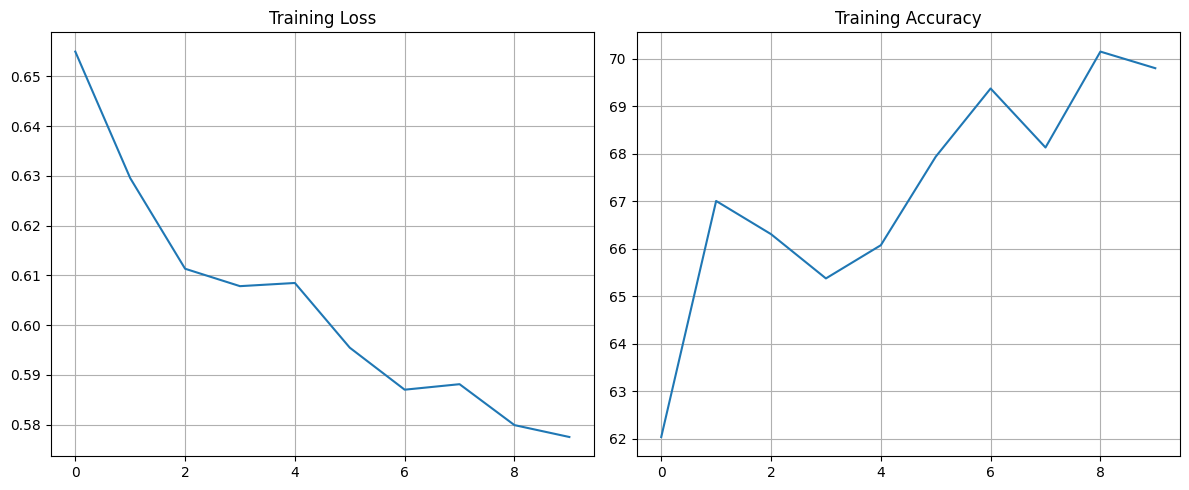

✅ Model saved to 'breast_cancer_model.pth'
🔍 Evaluating model...

📊 Test Accuracy: 60.51%
🧾 Classification Report:
              precision    recall  f1-score   support

      Benign       0.71      0.59      0.64       428
   Malignant       0.50      0.63      0.56       276

    accuracy                           0.61       704
   macro avg       0.60      0.61      0.60       704
weighted avg       0.63      0.61      0.61       704



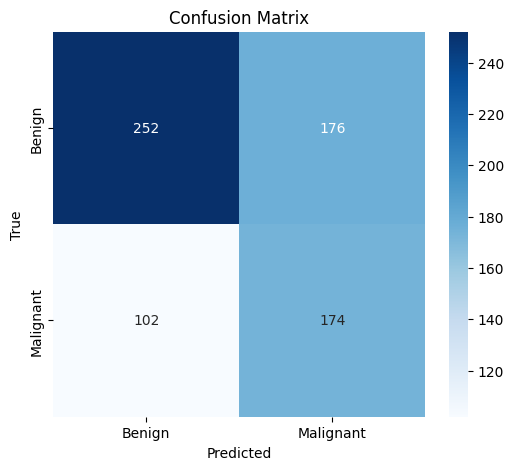

In [12]:
dataset_path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")
print(f"📁 Dataset path: {dataset_path}")

train_transforms, val_transforms = create_data_transforms()
train_dataset = CBISDDSMDataset(dataset_path, 'train', train_transforms, use_roi=True)
test_dataset = CBISDDSMDataset(dataset_path, 'test', val_transforms, use_roi=True)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

model = create_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(model, train_loader, val_loader, device, num_epochs=10)

print("🔍 Evaluating model...")
evaluate_model(model, test_loader, device)
